(time-series)=
# Time Series

In this chapter, we'll look at time series. If you haven't yet looked at the two sections on **pandas**, the [Data Quickstart](data-quickstart) and [Working with Data](working-with-data) chapters, it might be worth taking a quick spin through them first. You may also find it useful to be familiar with a few of the concepts from the previous Chapter, {ref}`time-intro`.

While we'll cover the basics here, the full set of time series functionality of **pandas** can be [found here](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html).

This chapter has benefitted from the [Python Data Science Handbook](https://jakevdp.github.io/PythonDataScienceHandbook/) by Jake VanderPlas, Tom Augspurger's [Effective Pandas](https://github.com/TomAugspurger/effective-pandas), [Applied Time Series for Fisheries and Environmental Sciences](https://nwfsc-timeseries.github.io/atsa-labs/), and the documentation of the [**arch**](https://arch.readthedocs.io/) package.

Let's imports a few of the packages we'll need first. You may need to install some of these; the Chapter on {ref}`code-preliminaries` covers how to install new packages.

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.graphics import tsaplots
from rich import inspect
import matplotlib.pyplot as plt
import matplotlib as mpl
import warnings

mpl.rcParams.update({"lines.linewidth": 1.2})
# Set max rows displayed for readability
pd.set_option("display.max_rows", 8)

# Set seed for random numbers
seed_for_prng = 78557
prng = np.random.default_rng(seed_for_prng)  # prng=probabilistic random number generator
# Turn off warnings
warnings.filterwarnings('ignore')

In [2]:
import matplotlib_inline.backend_inline

# Plot settings
plt.style.use(
    "https://github.com/aeturrell/coding-for-economists/raw/main/plot_style.txt"
)
matplotlib_inline.backend_inline.set_matplotlib_formats("svg")

## Introducing Time Series with **pandas**

[**pandas**](https://pandas.pydata.org/) is the workhorse of time series analysis in Python. The basic object is a *timestamp*. The `pd.to_datetime` function creates timestamps from strings that could reasonably represent datetimes. Let's see an example of using `pd.to_datetime` to create a timestamp and then inspect all of the methods and attributes of the created timestamp using **rich**'s `inspect` function.

In [3]:
date = pd.to_datetime("16th of February, 2020")
inspect(date)

╭───────── <class 'pandas._libs.tslibs.timestamps.Timestamp'> ─────────╮
│ Pandas replacement for python datetime.datetime object.              │
│                                                                      │
│ ╭──────────────────────────────────────────────────────────────────╮ │
│ │ Timestamp('2020-02-16 00:00:00')                                 │ │
│ ╰──────────────────────────────────────────────────────────────────╯ │
│                                                                      │
│             asm8 = numpy.datetime64('2020-02-16T00:00:00.000000000') │
│              day = 16                                                │
│      day_of_week = 6                                                 │
│      day_of_year = 47                                                │
│        dayofweek = 6                                                 │
│        dayofyear = 47                                                │
│    days_in_month = 29                                                │
│      daysinmonth = 29                                                │
│             fold = 0                                                 │
│             freq = None                                              │
│          freqstr = None                                              │
│             hour = 0                                                 │
│     is_leap_year = True                                              │
│     is_month_end = False                                             │
│   is_month_start = False                                             │
│   is_quarter_end = False                                             │
│ is_quarter_start = False                                             │
│      is_year_end = False                                             │
│    is_year_start = False                                             │
│              max = Timestamp('2262-04-11 23:47:16.854775807')        │
│      microsecond = 0                                                 │
│              min = Timestamp('1677-09-21 00:12:43.145224193')        │
│           minute = 0                                                 │
│            month = 2                                                 │
│       nanosecond = 0                                                 │
│          quarter = 1                                                 │
│       resolution = Timedelta('0 days 00:00:00.000000001')            │
│           second = 0                                                 │
│               tz = None                                              │
│           tzinfo = None                                              │
│            value = 1581811200000000000                               │
│             week = 7                                                 │
│       weekofyear = 7                                                 │
│             year = 2020                                              │
╰──────────────────────────────────────────────────────────────────────╯

This is of type `Timestamp` and you can see that it has many of the same properties as the built-in Python `datetime.datetime` class from the previous chapter. As with that, the default setting for `tz` (timezone) and `tzinfo` is `None`. There are some extra properties, though, such as `freq` for frequency, which will be very useful when it comes to manipulating time *series* as opposed to just one or two datetimes.

## Creating and Using Time Series

There are two main scenarios in which you might be creating time series using **pandas**: i) creating one from scratch or ii) reading in data from a file. Let's look at a few ways to do i) first. 

You can create a time series with **pandas** by taking a date as created above and extending it using **pandas** timedelta function:

In [4]:
date + pd.to_timedelta(np.arange(12), "D")

DatetimeIndex(['2020-02-16', '2020-02-17', '2020-02-18', '2020-02-19',
               '2020-02-20', '2020-02-21', '2020-02-22', '2020-02-23',
               '2020-02-24', '2020-02-25', '2020-02-26', '2020-02-27'],
              dtype='datetime64[ns]', freq=None)

This has created a datetime index of type `datetime65[ns]` (remember, an index is a special type of **pandas** column), where "ns" stands for nano-second resolution.

Another method is to create a range of dates (pass a frequency using the `freq=` keyword argument):

In [5]:
pd.date_range(start="2018/1/1", end="2018/1/8")

DatetimeIndex(['2018-01-01', '2018-01-02', '2018-01-03', '2018-01-04',
               '2018-01-05', '2018-01-06', '2018-01-07', '2018-01-08'],
              dtype='datetime64[ns]', freq='D')

Another way to create ranges is to specify the number of periods and the frequency:

In [6]:
pd.date_range("2018-01-01", periods=3, freq="H")

DatetimeIndex(['2018-01-01 00:00:00', '2018-01-01 01:00:00',
               '2018-01-01 02:00:00'],
              dtype='datetime64[ns]', freq='H')

Following the discussion of the previous chapter on timezones, you can also localise timezones directly in **pandas** dataframes:


In [7]:
dti = pd.date_range("2018-01-01", periods=3, freq="H").tz_localize("UTC")
dti.tz_convert("US/Pacific")

DatetimeIndex(['2017-12-31 16:00:00-08:00', '2017-12-31 17:00:00-08:00',
               '2017-12-31 18:00:00-08:00'],
              dtype='datetime64[ns, US/Pacific]', freq='H')

Now let's see how to turn data that has been read in with a non-datetime type into a vector of datetimes. This happens *all the time* in practice. We'll read in some data on job vacancies for information and communication jobs, ONS code UNEM-JP9P, and then try to wrangle the given "date" column into a **pandas** datetime column.

In [8]:
import requests

url = "https://api.ons.gov.uk/timeseries/JP9P/dataset/UNEM/data"

# Get the data from the ONS API:
df = pd.DataFrame(pd.json_normalize(requests.get(url).json()["months"]))
df["value"] = pd.to_numeric(df["value"])
df = df[["date", "value"]]
df = df.rename(columns={"value": "Vacancies (ICT), thousands"})
df.head()

,date,"Vacancies (ICT), thousands"
0,2001 MAY,50
1,2001 JUN,48
2,2001 JUL,47
3,2001 AUG,46
4,2001 SEP,44


We have the data in. Let's look at the column types that arrived.

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 255 entries, 0 to 254
Data columns (total 2 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   date                        255 non-null    object
 1   Vacancies (ICT), thousands  255 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 4.1+ KB


This is the default 'object' type, but we want the date column to have `datetime64[ns]`, which is a datetime type. Again, we use `pd.to_datetime`:

In [10]:
df["date"] = pd.to_datetime(df["date"])
df["date"].head()

0   2001-05-01
1   2001-06-01
2   2001-07-01
3   2001-08-01
4   2001-09-01
Name: date, dtype: datetime64[ns]

In this case, the conversion from the format of data that was put in of "2001 MAY" to datetime worked out-of-the-box. `pd.to_datetime` will always take an educated guess as to the format, but it won't always work out.

What happens if we have a more tricky-to-read-in datetime column? This frequently occurs in practice so it's well worth exploring an example. Let's create some random data with dates in an unusual format with month first, then year, then day, eg "1, '19, 29" and so on.

In [11]:
small_df = pd.DataFrame({"date": ["1, '19, 22", "1, '19, 23"], "values": ["1", "2"]})
small_df["date"]

0    1, '19, 22
1    1, '19, 23
Name: date, dtype: object

Now, if we were to run this via `pd.to_datetime` with no further input, it would misinterpret, for example, the first date as `2022-01-19`. So we must pass a bit more info to `pd.to_datetime` to help it out. We can pass a `format=` keyword argument with the format that the datetime takes. Here, we'll use `%m` for month in number format, `%y` for year in 2-digit format, and `%d` for 2-digit day. We can also add in the other characters such as `'` and `,`. You can find a list of datetime format identifiers in the previous chapter or over at [https://strftime.org/](https://strftime.org/).

In [12]:
pd.to_datetime(small_df["date"], format="%m, '%y, %d")

0   2019-01-22
1   2019-01-23
Name: date, dtype: datetime64[ns]

### Datetime Offsets

Our data, currently held in `df`, were read in as if they were from the *start* of the month but these data refer to the month that has passed and so should be for the *end* of the month. Fortunately, we can change this using a time offset.

In [13]:
df["date"] = df["date"] + pd.offsets.MonthEnd()
df.head()

,date,"Vacancies (ICT), thousands"
0,2001-05-31,50
1,2001-06-30,48
2,2001-07-31,47
3,2001-08-31,46
4,2001-09-30,44


While we used the `MonthEnd` offset here, there are many different offsets available. You can find a [full table of date offsets here](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#dateoffset-objects).

### The `.dt` accessor

When you have a datetime column, you can use the `.dt` accessor to grab lots of useful information from it such as the `minute`, `month`, and so on. Some that are functions, rather than just accessors of underlying properties, are followed by brackets, `()`, because they are functions. Here are a few useful examples:

In [14]:
from rich import print

print("Using `dt.day_name()`")
print(df["date"].dt.day_name().head())
print("Using `dt.isocalendar()`")
print(df["date"].dt.isocalendar().head())
print("Using `dt.month`")
print(df["date"].dt.month.head())

Using `dt.day_name()`

0    Thursday
1    Saturday
2     Tuesday
3      Friday
4      Sunday
Name: date, dtype: object

Using `dt.isocalendar()`

year  week  day
0  2001    22    4
1  2001    26    6
2  2001    31    2
3  2001    35    5
4  2001    39    7

Using `dt.month`

0    5
1    6
2    7
3    8
4    9
Name: date, dtype: int64

### Creating a datetime index and setting the frequency

For the subsequent parts, we'll set the datetime column to be the index of the dataframe. *This is the standard setup you will likely want to use when dealing with time series.*

In [15]:
df = df.set_index("date")
df.head()

,"Vacancies (ICT), thousands"
date,
2001-05-31,50
2001-06-30,48
2001-07-31,47
2001-08-31,46
2001-09-30,44


Now, if we look at the first few entries of the index of dataframe (a datetime index) using `head` as above, we'll see that the `freq=` parameter is set as `None`.

In [16]:
df.index[:5]

DatetimeIndex(['2001-05-31', '2001-06-30', '2001-07-31', '2001-08-31',
               '2001-09-30'],
              dtype='datetime64[ns]', name='date', freq=None)

This can be set for the whole dataframe using the `asfreq` function:

In [17]:
df = df.asfreq("M")
df.index[:5]

DatetimeIndex(['2001-05-31', '2001-06-30', '2001-07-31', '2001-08-31',
               '2001-09-30'],
              dtype='datetime64[ns]', name='date', freq='M')

Although most of the time it doesn't matter about the fact that `freq=None`, some aggregation operations need to know the frequency of the time series in order to work and it's good practice to set it if your data *are* regular. You can use `asfreq` to go from a higher frequency to a lower frequency too: the last entry from the higher frequency that aligns with the lower frequency will be taken, for example in going from months to years, December's value would be used.

Note that trying to set the frequency when your datetime index doesn't match up to a particular frequency will cause errors or problems.

A few useful frequencies to know about are in the table below; all of these can be used with `pd.to_datetime` too.

| Code  | Represents                                                          |
|-------|---------------------------------------------------------------------|
| D     | Calendar day                                                        |
| W     | Weekly                                                              |
| M     | Month end                                                           |
| Q     | Quarter end                                                         |
| A     | Year end                                                            |
| H     | Hours                                                               |
| T     | Minutes                                                             |
| S     | Seconds                                                             |
| B     | Business day                                                        |
| BM    | Business month end                                                  |
| BQ    | Business quarter end                                                |
| BA    | Business year end                                                   |
| BH    | Business hours                                                      |
| MS    | Month start                                                         |
| QS    | Quarter start                                                       |
| W-SUN | Weeks beginning with Sunday (similar for other days)                |
| 2M    | Every 2 months (works with other combinations of numbers and codes) |

## Making Quick Time Series Plots

Having managed to put your time series into a dataframe, perhaps converting a column of type string into a colume of type datetime in the process, you often just want to see the thing! We can achieve this using the `plot` command, as long as we have a datetime index.


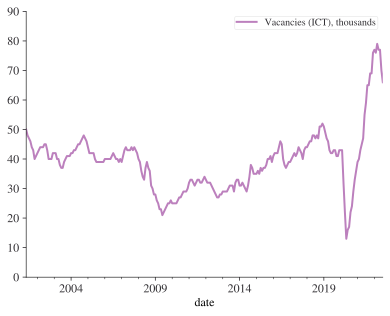

In [18]:
df.plot();

## Resampling, Rolling, and Shifting

Now our data have a *datetime index*, some common time series operations are made very easy for us.

### Resampling

Quite frequently, there is a situation in which one would like to change the frequency of a given time series. A time index-based dataframe makes this easy via the `resample` function. `resample` must be told *how* you'd like to resample the data, for example via the mean or median. Here's an example resampling the monthly data to annual and taking the mean:

In [19]:
df.resample("A").mean()

,"Vacancies (ICT), thousands"
date,
2001-12-31,44.875000
2002-12-31,42.666667
2003-12-31,39.833333
2004-12-31,44.833333
...,...
2019-12-31,44.250000
2020-12-31,27.500000
2021-12-31,56.000000
2022-12-31,74.571429


As resample is just a special type of aggregation, it can work with all of the usual functions that aggregations do, including in-built functions or user-defined functions.

In [20]:
df.resample("5A").agg(["mean", "std"]).head()

Vacancies (ICT), thousands           
                                 mean        std
date                                            
2001-12-31                  44.875000   3.482097
2006-12-31                  41.616667   2.511611
2011-12-31                  32.300000   6.832872
2016-12-31                  34.366667   4.957332
2021-12-31                  43.450000  11.915557

Resampling can go up in frequency (up-sampling) as well as down, but we no longer need to choose an aggregation function, we must now choose how we'd like to fill in the gaps for the frequencies we didn't have in the original data. In the example below, they are just left as NaNs.

In [21]:
df.resample("D").asfreq()

,"Vacancies (ICT), thousands"
date,
2001-05-31,50.0
2001-06-01,NaN
2001-06-02,NaN
2001-06-03,NaN
...,...
2022-07-28,NaN
2022-07-29,NaN
2022-07-30,NaN
2022-07-31,66.0


Options to fill in missing time series data include using `bfill` or `ffill` to fill in the blanks based on the next or last available value, respectively, or `interpolate` (note how only the first 3 NaNs are replaced using the `limit` keyword argument):

In [22]:
df.resample("D").interpolate(method="linear", limit_direction="forward", limit=3)[:6]

,"Vacancies (ICT), thousands"
date,
2001-05-31,50.000000
2001-06-01,49.933333
2001-06-02,49.866667
2001-06-03,49.800000
2001-06-04,NaN
2001-06-05,NaN


We can see the differences between the filling methods more clearly in this stock market data, following a chart by Jake Vanderplas.

In [23]:
# Get stock market data
import pandas_datareader as web

xf = web.DataReader("AAPL", "stooq", start="2017-01-01", end="2019-06-01")
xf = xf.sort_index()

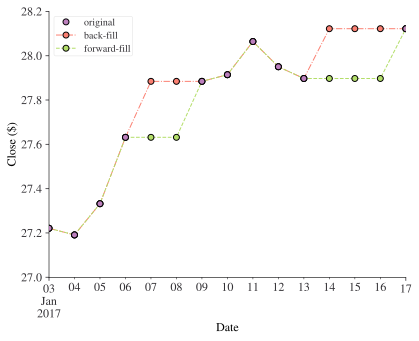

In [24]:
fig, ax = plt.subplots()
data = xf.iloc[:10, 3]
cycle = ax._get_lines.prop_cycler

data.asfreq("D").plot(ax=ax, marker="o", linestyle="None", zorder=3)
data.asfreq("D", method="bfill").plot(
    ax=ax, style="-.o", lw=1, color=next(cycle)["color"]
)
data.asfreq("D", method="ffill").plot(
    ax=ax, style="--o", lw=1, color=next(cycle)["color"]
)
ax.set_ylabel("Close ($)")
ax.legend(["original", "back-fill", "forward-fill"]);

### Rolling Window Functions

The `rolling` and `ewm` methods are both rolling window functions. The first includes functions of the sequence

$$
y_t = f(\{x_{t-i} \}_{i=0}^{i=R-1})
$$

where $R$ is the number of periods to use for the rolling window. For example, if the function is the mean, then $f$ takes the form $\frac{1}{R}\displaystyle\sum_{i=0}^{i=R-1} x_{t-i}$.

The example below is a 2-period rolling mean:

In [25]:
df.rolling(2).mean()

,"Vacancies (ICT), thousands"
date,
2001-05-31,NaN
2001-06-30,49.0
2001-07-31,47.5
2001-08-31,46.5
...,...
2022-04-30,78.0
2022-05-31,77.0
2022-06-30,73.5
2022-07-31,68.0


The `ewm` includes the class of functions where data point $x_{t-i}$ has a weight $w_i = (1-\alpha)^i$. As $0 < \alpha < 1$, points further back in time are given less weight. For example, an exponentially moving average is given by

$$
y_t = \frac{x_t + (1 - \alpha)x_{t-1} + (1 - \alpha)^2 x_{t-2} + ...
+ (1 - \alpha)^t x_{0}}{1 + (1 - \alpha) + (1 - \alpha)^2 + ...
+ (1 - \alpha)^t}
$$

The example below shows the code for the exponentially weighted moving average:

In [26]:
df.ewm(alpha=0.2).mean()

,"Vacancies (ICT), thousands"
date,
2001-05-31,50.000000
2001-06-30,48.888889
2001-07-31,48.114754
2001-08-31,47.398374
...,...
2022-04-30,71.036769
2022-05-31,72.229415
2022-06-30,71.783532
2022-07-31,70.626825


Let's see these methods together on the stock market data.

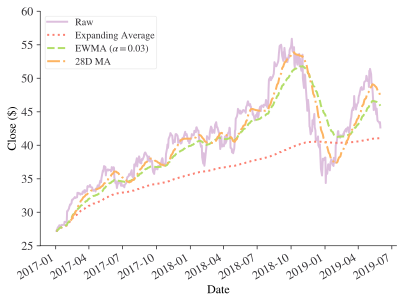

In [27]:
fig, ax = plt.subplots()
roll_num = 28
alpha = 0.03
xf["Close"].plot(label="Raw", alpha=0.5)
xf["Close"].expanding().mean().plot(label="Expanding Average", style=":")
xf["Close"].ewm(alpha=alpha).mean().plot(
    label=f"EWMA ($\\alpha=${alpha:.2f})", style="--"
)
xf["Close"].rolling(roll_num).mean().plot(label=f"{roll_num}D MA", style="-.")
ax.legend()
ax.set_ylabel("Close ($)");

For more tools to analyse stocks, see the [**Pandas TA**](https://twopirllc.github.io/pandas-ta/) package.

We can also use `rolling` as an intermediate step in creating more than one type of aggregation:

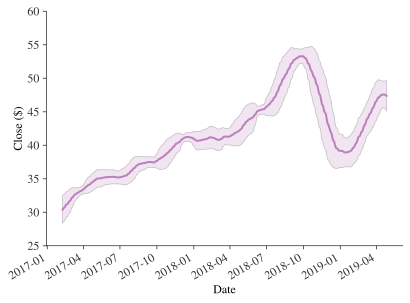

In [28]:
roll = xf["Close"].rolling(50, center=True)

fig, ax = plt.subplots()
m = roll.agg(["mean", "std"])
m["mean"].plot(ax=ax)
ax.fill_between(m.index, m["mean"] - m["std"], m["mean"] + m["std"], alpha=0.2)
ax.set_ylabel("Close ($)");

### Shifting

Shifting can move series around in time; it's what we need to create leads and lags of time series. Let's create a lead and a lag in the data. Remember that a lead is going to shift the pattern in the data to the left (ie earlier in time), while the lag is going to shift patterns later in time (ie to the right).

In [29]:
lead = 12
lag = 3
orig_series_name = df.columns[0]
df[f"lead ({lead} months)"] = df[orig_series_name].shift(-lead)
df[f"lag ({lag} months)"] = df[orig_series_name].shift(lag)
df.head()

,"Vacancies (ICT), thousands",lead (12 months),lag (3 months)
date,,,
2001-05-31,50,44.0,NaN
2001-06-30,48,45.0,NaN
2001-07-31,47,45.0,NaN
2001-08-31,46,43.0,50.0
2001-09-30,44,40.0,48.0


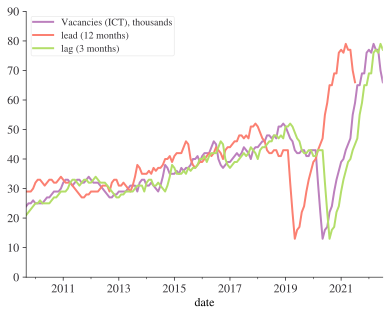

In [30]:
df.iloc[100:300, :].plot();

## Correlations

In this section, we'll look at some different ways of comparing time series using simple metrics.

### Autocorrelation

First, what about comparing a time series to itself? The autocorrelation of a time series tells you how persistent it is. The econometrics package [**statsmodels**]() has some tools for this, most notably `statsmodels.tsa.stattools.acf`. Sometimes what you want is just a visual cue though, in which case the code below produces a nice chart.

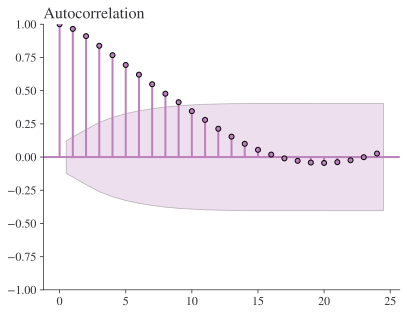

In [31]:
fig = tsaplots.plot_acf(df["Vacancies (ICT), thousands"], lags=24)
plt.show()

Rememebr that the autocorrelation can tell you about likely terms to include in a moving average (MA) model.

We can also look at the *partial autocorrelation*, which, at a given lag, is the correlation that results after removing the effect of any correlations due to the terms at shorter lags. It can be computer via the `statsmodels.tsa.stattools.pacf` function, but here's a chart:

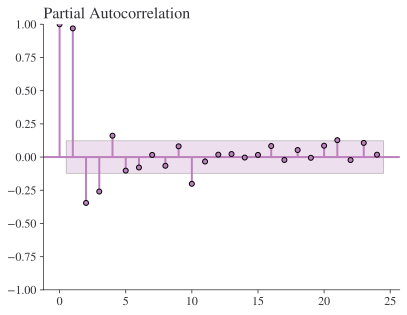

In [32]:
fig = tsaplots.plot_pacf(df["Vacancies (ICT), thousands"], lags=24)
plt.show()

Remember that the partial autocorrelation function can tell you about likely terms to include in an autoregressive (AR) model.

By looking at both the ACF and PACF, you can get an idea of what terms would be good to include in *both* an MA and AR model which, combined, make an ARMA model. It's also worth noting that, if the ACF and PACF do not seem to tail off, the series is likely to be non-stationary and differencing will be needed if you are going to model it with an ARMA approach.

### Correlations with Other Series

To compute correlations with other time series, a popular choice is the cross-correlation function (CCF). Confusingly, there are different definitions of this object in statistics and signal processing. In statistics, it's given by

$$
r_k = \frac{g_k}{\sqrt{\sigma_x\sigma_y}};
$$

where

$$
g_k = \frac{1}{n}\sum_{t=1}^{n-k} \left(y_t-\bar{y}\right) \left(x_{t+k}-\bar{x}\right),
$$

and $k$ is set by a rule of thumb, usually something like $10 \log_{10}\left(\min(|x|, |y|)/2\right)$. $g_k$ is the 'sliding' dot product of $y$, the response, with $x$, the predictor, up to the $k$ th lag.

The default cross-correlation function in **statsmodels** is different. It only looks forward, and it computes *all* possible lags. You can call it via `sm.ccf` if you have already run `import statsmodels.api as sm`.

We'll use the standard stats treatment here, but we'll need to define a function to do the computation we need. Then we'll apply the CCF to a classic example: the response of the number of Lynx trapped (in Canada) to sunspot activity.

First, defining the function. We'll make use of the signal processing `ss.correlate` function but modify it so that adopts the definition of CCF used in statistics:

In [33]:
import scipy.signal as ss


def ccf_stats(x, y, lag_max=None):
    if not lag_max:
        lag_max = int(10 * np.log10(min(len(x), len(y)) / 2))
    result = ss.correlate(x - np.mean(x), y - np.mean(y), method="direct") / (
        np.std(y) * np.std(x) * len(y)
    )
    length = (len(result) - 1) // 2
    lo = length - lag_max
    hi = length + (lag_max + 1)
    return result[lo:hi]

Now let's grab the two different datasets and merge them, taking a quick look while we're at it:

In [34]:
lynx_df = pd.read_csv(
    "https://vincentarelbundock.github.io/Rdatasets/csv/datasets/lynx.csv", index_col=0
)
spot_df = pd.read_csv(
    "https://vincentarelbundock.github.io/Rdatasets/csv/datasets/sunspot.year.csv",
    index_col=0,
)
df = pd.merge(lynx_df, spot_df, on="time", how="inner", suffixes=("_lynx", "_sunspots"))
df = df.set_index("time")
df.head()

,value_lynx,value_sunspots
time,,
1821,269,6.6
1822,321,4.0
1823,585,1.8
1824,871,8.5
1825,1475,16.6


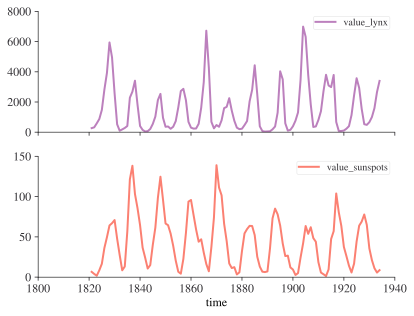

In [35]:
df.plot(subplots=True, ylim=(0, None));

Let's use our defined function on the data. We'll add in a rough confidence interval of $\pm \frac{2}{\sqrt{n}}$.

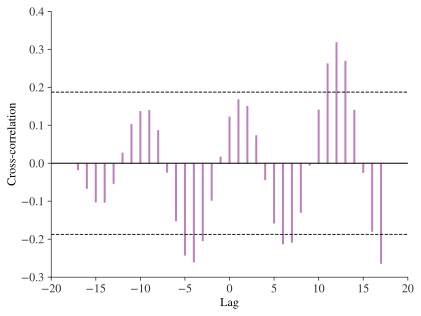

In [36]:
fig, ax = plt.subplots()
ccf_res_stats = ccf_stats(df["value_sunspots"], np.log(df["value_lynx"]))
conf_int = 2.0 / np.sqrt(len(df))
ax.stem(
    range(-int(len(ccf_res_stats) / 2), int(len(ccf_res_stats) / 2) + 1),
    ccf_res_stats,
    basefmt=" ",
    markerfmt=" ",
)
ax.axhline(-conf_int, ls="--", lw=0.9, color="k")
ax.axhline(conf_int, ls="--", lw=0.9, color="k")
ax.axhline(0, color="k", lw=1)
ax.set_ylabel("Cross-correlation")
ax.set_xlabel("Lag")
plt.show()

The significant correlations at lags of -3 to -5 seem to suggest that lynx numbers fall in the 3 to 5 years after high sunspot activity.

## Transformations

There are many reasons why you might want to perform transformations on series, including to normalise data and to adjust for changes (such as inflation). In this section, we'll look at some of the most common transforms for time series.

### Mathematical Transformations

The usual transformations that we know and love from other series of numerical data can equally be applied to time series, for example the log and power transforms. Let's see some of these in action using data on US GDP.

In [37]:
import pandas_datareader.data as web
from datetime import datetime

ts_start_date = pd.to_datetime("2009-01-01")

df = web.DataReader("NA000334Q", "fred", start=ts_start_date, end=datetime.now())
df.columns = ["gdp"]
df.head()

,gdp
DATE,
2009-01-01,3522117.0
2009-04-01,3598010.0
2009-07-01,3623204.0
2009-10-01,3734738.0
2010-01-01,3602418.0


Now let's create new columns for each of log, square, and square root transforms. All of these mathematical transformations can be found in **numpy**.

In [38]:
df["log"] = np.log(df["gdp"])
df["square"] = np.power(df["gdp"], 2)
df["sqrt"] = np.sqrt(df["gdp"])
df.head()

,gdp,log,square,sqrt
DATE,,,,
2009-01-01,3522117.0,15.074573,1.240531e+13,1876.730402
2009-04-01,3598010.0,15.095891,1.294568e+13,1896.842113
2009-07-01,3623204.0,15.102869,1.312761e+13,1903.471565
2009-10-01,3734738.0,15.133188,1.394827e+13,1932.547024
2010-01-01,3602418.0,15.097116,1.297742e+13,1898.003688


A very common transformation is to change to growth space. In time series maths, this is $\frac{y_t}{y_{t-1}}$ for period-on-period growth or, say, $\frac{y_t}{y_{t-4}}$ for growth relative to 4 periods ago.

Let's add in quarter-on-quarter-a-year-ago and quarter-on-quarter growth rates to our growing list of transforms:

In [39]:
df["q_on_q"] = df["gdp"].pct_change(1) * 100
df["q_on_q_yr_ago"] = df["gdp"].pct_change(4) * 100
df.tail()

,gdp,log,square,sqrt,q_on_q,q_on_q_yr_ago
DATE,,,,,,
2021-04-01,5711844.0,15.558052,3.262516e+13,2389.946443,6.410316,17.120936
2021-07-01,5822816.0,15.577295,3.390519e+13,2413.051181,1.942840,9.816030
2021-10-01,6121436.0,15.627307,3.747198e+13,2474.153593,5.128446,11.500510
2022-01-01,5981019.0,15.604102,3.577259e+13,2445.612193,-2.293857,11.424983
2022-04-01,6286076.0,15.653848,3.951475e+13,2507.204818,5.100419,10.053356


Another classic transform you might need is to de-mean your data. We are transforming such that

$$
y_t' = y_t - \langle y_t \rangle
$$

where the angular brackets denote a mean. Here's an example of that:

In [40]:
df["demean"] = df["gdp"] - df["gdp"].mean()
df[["gdp", "demean"]].tail()

,gdp,demean
DATE,,
2021-04-01,5711844.0,1.077773e+06
2021-07-01,5822816.0,1.188745e+06
2021-10-01,6121436.0,1.487365e+06
2022-01-01,5981019.0,1.346948e+06
2022-04-01,6286076.0,1.652005e+06


Be wary though! The mean is a function that, by default, uses all time periods, so you need to be careful if you're working on a real-time data problem such as forecasting. In this case you only want to use the mean *up to that point in time* to demean a series. Mathematically, this is

$$
y_t' = y_t - \frac{1}{t+1}\displaystyle{\sum_{\tau=0}^{\tau=t} y_\tau}
$$

To do this, we can make use of the **pandas** *expanding* functionality we saw earlier. Here's an example of real-time demeaning:

In [41]:
df["real_time_demean"] = df["gdp"] - df["gdp"].expanding().mean()
df[["gdp", "real_time_demean"]].head()

,gdp,real_time_demean
DATE,,
2009-01-01,3522117.0,0.000000
2009-04-01,3598010.0,37946.500000
2009-07-01,3623204.0,42093.666667
2009-10-01,3734738.0,115220.750000
2010-01-01,3602418.0,-13679.400000


Note how the second real-time demeaned entry is the second entry for GDP minus the average of the second and first entries of GDP. A more general way of avoiding data leakage is to use **scikit-learn**'s [pipeline](https://scikit-learn.org/stable/modules/compose.html#pipeline) functionality.

Let's move on to another classic transformation: differences. These are given by

$$
\Delta y_t = y_t - y_{t-1}
$$

Note that, in this case, the first entry in the differences won't be defined (ie appears as `NaN`) because there is no $\text{gdp}_{t=-1}$. Use `diff(n)` to get $y_t - y_{t-n}$.

In [42]:
df["difference"] = df["gdp"].diff()
df[["gdp", "difference"]].head()

,gdp,difference
DATE,,
2009-01-01,3522117.0,NaN
2009-04-01,3598010.0,75893.0
2009-07-01,3623204.0,25194.0
2009-10-01,3734738.0,111534.0
2010-01-01,3602418.0,-132320.0


#### The Box-Cox Transform

This transform actually nests power transforms and logarithms, depending on the value of a parameter that is usually denoted $\lambda$. The transform is given by

$$
y_t'  =
    \begin{cases}
      \ln(y_t) & \text{if $\lambda=0$};  \\
      (y_t^\lambda-1)/\lambda & \text{otherwise}.
    \end{cases}
$$

How do you choose $\lambda$? One way is to choose such that the transformed data resemble a normal distribution. Let's see a couple of examples, including an optimal value for $\lambda$ as determined by **scipy**.

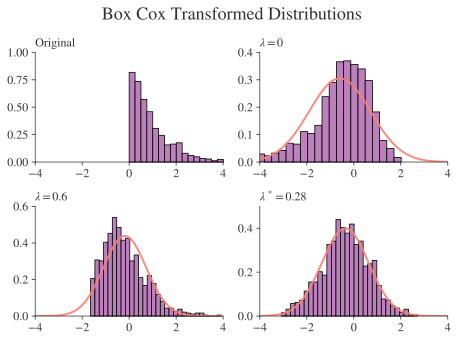

In [43]:
from scipy import stats

data = prng.exponential(size=1000)
# Last entry of the list gets the optimal value for lambda
λ_values = [0, 0.6, stats.boxcox(data)[1]]
# One extra plot for the original data
num_plots = len(λ_values) + 1
# For fitting a normal distribution
x = np.linspace(-5, 5, 100)
bins = 30


fig, axes = plt.subplots(ncols=num_plots // 2, nrows=num_plots - num_plots // 2)
axes = axes.flatten()
for i, ax in enumerate(axes[1:]):
    values = stats.boxcox(data, lmbda=λ_values[i])
    ax.hist(values, density=True, bins=bins)
    title = r"$\lambda =$" + f"{λ_values[i]}"
    if i == len(λ_values) - 1:
        title = r"$\lambda^*=$" + f"{λ_values[i]:.2f}"
    ax.set_title(title, size=12)
    mu, std = stats.norm.fit(values)
    p = stats.norm.pdf(x, mu, std)
    ax.plot(x, p, linewidth=2, alpha=0.9)
axes[0].hist(data, density=True, bins=bins)
axes[0].set_title("Original", size=12)
[ax.set_xlim(-4, 4) for ax in axes]
plt.suptitle("Box Cox Transformed Distributions", size=18)
plt.tight_layout()
plt.show()

You can reverse the Box Cox transform using **scipy**'s `scipy.special.inv_boxcox(y, lmbda)` function. This is useful if you have performed an operation on the transformed data, for example a forecast, and want to transform the outputs back into the original space.

### Adjusting for Inflation

This one's mighty important! As every economist knows, the value of money changes over time: a dollar in 1963 does not buy the same bundle of goods and services as a dollar in 2021 would. The price level has changed considerably between those two times. Let's say we have prices in year $t$ given by $y_t$. Then the price of that same good or service in year $\omega$ is

$$
y_\omega = y_t \frac{\pi_{\omega}} {\pi_t}
$$

for example, to find the price of a television in 2021 dollars using data on televisions from 2000 we would do $y_{2021} = y_{2000} \cdot \frac{\pi_{2021}}{\pi_{2000}}$. Note that $\pi$ here is being used as a symbol for inflation, *not* the ratio of a circle's circumference to its diameter in Euclidean space!

Let's see a real example using data on an important good, cheese. We'll grab the average price per pound of cheese in US cities and adjust it to be in 2012 dollars using the PCE (personal consumption expenditure) price index.

In [44]:
fred_codes = {
    "PCEPI": "inflation",
    "APU0000710212": "cheddar",  # Avg price per pound in US cities
}


cdf = (
    pd.concat(
        [
            web.DataReader(
                x,
                "fred",
                start=pd.to_datetime("2000-01-01"),
                end=pd.to_datetime("2021-01-01"),
            )
            for x in fred_codes.keys()
        ],
        axis=1,
    )
    .rename(columns=fred_codes)
    .groupby(pd.Grouper(freq="A"))
    .mean()
)
cdf.head()

,inflation,cheddar
DATE,,
2000-12-31,78.090500,3.829917
2001-12-31,79.656167,4.026917
2002-12-31,80.702083,4.218083
2003-12-31,82.397583,3.948417
2004-12-31,84.442750,4.272917


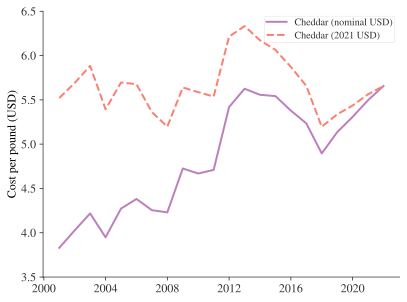

In [45]:
cdf["cheddar_i_adjust"] = (
    cdf.loc["2021-12-31", "inflation"] * cdf["cheddar"] / cdf["inflation"]
)
fig, ax = plt.subplots()
ax.plot(cdf.index, cdf["cheddar"], label="Cheddar (nominal USD)")
ax.plot(cdf.index, cdf["cheddar_i_adjust"], label="Cheddar (2021 USD)", linestyle="--")
ax.set_ylabel("Cost per pound (USD)")
ax.legend()
plt.show()

We can see from the chart that, once adjusted for inflation, cheese was not such a great bargain in the noughties as it appeared from the nominal cost per pound. But the big fall in cheese prices between 2013 and 2017 *was* a real effect and coincided with the United States' [great cheese surplus](https://www.vox.com/2016/10/13/13268980/cheese-glut-united-states). Supply and demand work! Of course, the costs are the same in 2021 dollars.

### Feature Engineering

Feature engineering, or feature extraction, is just data science talk for transformations. And, just as with the transformations we've seen, you need to take care whether you're running them as if in real time or not, and whether that matters.

So, is there any real difference between time series econometrics transformations and those found in data science? There isn't in principle, but in practice the transformations used in data science are a superset of those typically used in econometrics, often because data scientists are trying to squeeze every last drop of predictability out of a time series and don't mind creating 100s of "features", aka regressors, to do it.

In the simplest and most naive case, time series feature engineering just involve throwing the kitchen sink at features, ie extracting every metric you can think of: mean, std, max, min, difference of maximum and minimum values, median, median absolute deviation, number of peaks, skewness, kurtosis, etc, etc.

There are a wide range of time series feature extraction packages available in Python. Some examples are [**tsfresh**](https://tsfresh.readthedocs.io/), [**featuretools**](https://featuretools.alteryx.com/en/stable/getting_started/handling_time.html#Handling-Time) (not just time series), [**tsfel**](https://tsfel.readthedocs.io/), and Facebook's [**kats**](https://facebookresearch.github.io/Kats/) which is very comprehensive but not as lightweight as it claims (it offers forecasting, detection, and time series feature extraction but because it depends on STAN and PyStan, you may have issues using it on Windows—especially on corporate IT systems that are locked down). You can get a sense of the typical features that you can extract from these packages from the default list of [features extracted by **tsfresh**](https://tsfel.readthedocs.io/en/latest/descriptions/feature_list.html).

## Stationarity and Unit Root Testing

This section is indebted to the excellent documentation of the [**arch**](https://arch.readthedocs.io/) (Autoregressive Conditional Heteroskedasticity) package. To install **arch** with conda, the conda comand is `conda install -c conda-forge arch-py`. Conda forge is a community-led effort to increase the number of packages that can be conda installed; `-c conda-forge` in the install command tells conda to do an install from the conda-forge repository of packages, while `arch-py` is the package name. If you're not using conda, the command is `pip install arch-py`. If you like the **arch** package, you can head over to [the code repository](https://github.com/bashtage/arch) and give it a star on GitHub.

Remember that a stationary process is a stochastic process whose unconditional joint probability distribution does not change when shifted in time and which, consequently, retains its parameters over time (in contrast to the case with a series with a trend in the mean). The transformations of the previous section give some good ideas as to how to transform stationary series, and we already saw some visual cues with auto- and partial auto-correlations, but here we'll be looking at formal statistical tests of whether a series is stationary.

As an example dataset to test, we will use the Default premium, the difference between the yields of BAA and AAA rated corporate bonds. Let's import the **arch** package, **statsmodels** time series functions, and grab **arch**'s built-in default premium data.

Date
1919-01-01    1.77
1919-02-01    1.85
1919-03-01    1.76
1919-04-01    1.79
1919-05-01    1.70
Name: default, dtype: float64

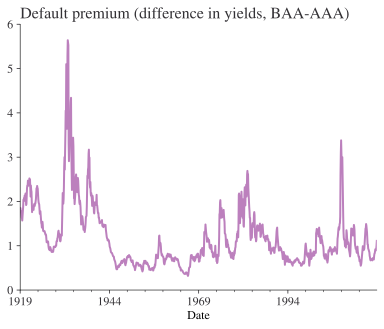

In [46]:
import arch.data.default
from arch.unitroot import ADF
from arch.unitroot import KPSS

default_data = arch.data.default.load()
default = default_data.BAA.copy()
default.name = "default"
default = default - default_data.AAA.values
print(default.head())
default.plot(title="Default premium (difference in yields, BAA-AAA)");

Let's now do some unit root testing.

### Augmented Dickey-Fuller Test

The Augmented Dickey-Fuller test is the most common unit root test. It is a regression of the first difference of the variable on its lagged level as well as additional lags of the first difference. The null is that the series contains a unit root, and the (one-sided) alternative is that the series is stationary.

By default, the number of lags is selected by minimising the AIC (Akaike information criterion) across a range of lag lengths (which can be set using `max_lag` when initializing the model). Additionally, the basic test includes a constant in the regression.

This is the regression equation:

$$
\Delta y_t = \alpha + \beta t + \gamma y_{t-1} + \delta_1 \Delta y_{t-1} + \cdots + \delta_{p-1} \Delta y_{t-p+1} + \varepsilon_t,
$$

where ${\displaystyle \alpha }$ is the constant, ${\displaystyle \beta }$ is the coefficient on a time trend and ${\displaystyle p}$ the lag order of the autoregressive process. Imposing the constraints ${\displaystyle \alpha}=0$ and ${\displaystyle \beta } =0$ corresponds to modelling a random walk and using the constraint ${\displaystyle \beta } =0$ corresponds to modelling a random walk with a drift.

These settings correspond to passing a keyword argument, `trend`, with the following options:

 - 'nc' : No deterministic terms

 - 'c' : Constant only

 - 'ct' : Constant and time trend

 - 'ctt' : Constant, time trend and time-trend squared

Let's see the result of the ADF test running on the default data.

In [47]:
# Create an ADF object with the default data
adf = ADF(default)
# Check the results of the test with the standard settings
adf.summary()

Test Statistic,-3.356
P-value,0.013
Lags,21


To change the model specification, create a new object using the relevant keyword arguments:

In [48]:
adf = ADF(default, trend="ct", lags=5)
adf.summary()

Test Statistic,-3.786
P-value,0.017
Lags,5


As an ADF test is just a regression, you can get that out of the output too:

In [49]:
print(adf.regression.summary())

OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.095
Model:                            OLS   Adj. R-squared:                  0.090
Method:                 Least Squares   F-statistic:                     17.83
Date:                Fri, 16 Sep 2022   Prob (F-statistic):           1.30e-22
Time:                        16:50:16   Log-Likelihood:                 630.15
No. Observations:                1194   AIC:                            -1244.
Df Residuals:                    1186   BIC:                            -1204.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Level.L1      -0.0248      0.007     -3.786      0.000      -0.038      -0.012
Diff.L1        0.2229      0.029      7.669      0.000       0.166       0.280
Diff.L2       -0.0525      0.030     -1.769      0.077      -0.111       0.006
Diff.L3       -0.1363      0.029     -4.642      0.000      -0.194      -0.079
Diff.L4       -0.0510      0.030     -1.727      0.084      -0.109       0.007
Diff.L5        0.0440      0.029      1.516      0.130      -0.013       0.101
const          0.0383      0.013      2.858      0.004       0.012       0.065
trend      -1.586e-05   1.29e-05     -1.230      0.219   -4.11e-05    9.43e-06
==============================================================================
Omnibus:                      665.553   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           146083.295
Skew:                          -1.425   Prob(JB):                         0.00
Kurtosis:                      57.113   Cond. No.                     5.70e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.7e+03. This might indicate that there are
strong multicollinearity or other numerical problems.

### KPSS Testing

The KPSS test differs from ADF in that the *null* hypothesis is that the time series is a stationary process and the *alternative* is a unit root.

In [50]:
kpss = KPSS(default)
kpss.summary()

Test Statistic,1.088
P-value,0.002
Lags,20


### Other Unit Root Tests

**arch** also contains the Phillips-Perron, Zivot-Andrews, and Dickey-Fuller GLS tests; see [here](https://arch.readthedocs.io/en/latest/unitroot/unitroot_examples.html) for more information.

## Seasonality

This section is indebted to [Chad Fulton](http://www.chadfulton.com/)'s [notes](https://github.com/ChadFulton/sm-notebooks-2021/blob/main/002-seasonal-adjustment.ipynb). Chad is an economist at the Federal Reserve Board of Governors.

Seasonality is when you find recurring, highly predictable changes in time series based on known events. From the point of view of analysis, they're often not all that interesting and what we *really* want to know is what's happening with the underlying series. But to find out, we have to strip out all of that seasonal variation. This is typically done by describing a model that can decompose a series into seasonal and non-seasonal effects.

Seasonal patterns repeat; every quarter, every month, every week, every day, and now—for tech firms—even intra-day seasonal frequencies are a problem econometricians need to worry about.

We will look at some simple and not-as-simple approaches to seasonal adjustment.

We'll look at the New York Times COVID 19 data for this, with a bit of pre-processing.

In [51]:
# Extract: download the data (here, load the CSV directly from the URL)
df = pd.read_csv(
    'https://raw.githubusercontent.com/nytimes/covid-19-data/master/us.csv',
    index_col=['date'], parse_dates=['date']).asfreq(freq='D')

# Transform: add new columns with useful transformations
df['new_cases'] = df['cases'].diff()
df = df.loc['2020-04-01':"2021-02-01", ['new_cases']]
df.head()

,new_cases
date,
2020-04-01,26930.0
2020-04-02,29717.0
2020-04-03,32318.0
2020-04-04,35099.0
2020-04-05,25616.0


Let's plot the data (remember: always plot the data)

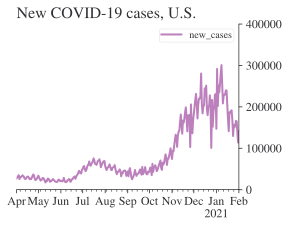

In [52]:
def plot_covid_data(dataframe):
    fig, ax = plt.subplots(figsize=(4, 3))
    dataframe.plot(ax=ax)
    ax.yaxis.tick_right()
    ax.spines['right'].set_visible(True)
    ax.spines['left'].set_visible(False)
    ax.ticklabel_format(axis='y', style='plain')
    ax.set_xlabel("")
    ax.set_title("New COVID-19 cases, U.S.")

plot_covid_data(df)

Already we can see that there's a lot of high-frequency variation in these data, with variation that gets stronger over time and some holiday-based outliers. Let's hone in on a few months to make it easier to see what's happening:

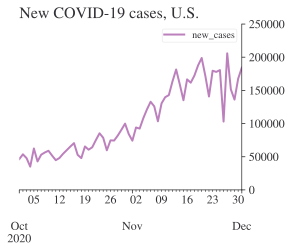

In [53]:
plot_covid_data(df.loc["2020-10-01":"2020-12-01"])

Now it's clear there's a strong weekly pattern (or *every 7th entry* in our daily frequency data).

In thinking about a series, an early choice we need to make is whether we think it is multiplicative, and so has a function form like

$$
y_t = \underbrace{\mu_t}_\text{trend} \times \underbrace{\gamma_t}_\text{seasonal} \times \underbrace{\varepsilon_t}_\text{residual}
$$

or like

$$
y_t = \underbrace{\mu_t}_\text{trend} + \underbrace{\gamma_t}_\text{seasonal} + \underbrace{\varepsilon_t}_\text{residual}
$$

As the increase in COVID-19 cases is the result of a multiplicative process, the former is more likely here. So the first thing we do is take the log of the series (we could also have used a Box-Cox transform). This will transform our data to the second case.

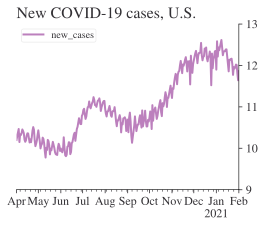

In [54]:
df = np.log(df)
plot_covid_data(df)

Now let's try some methods of seasonal adjustment!

### Classical Seasonal Decomposition

This will proceed by estimating the trend component $(\mu_t)$ by applying a moving average (or double moving average, if the seasonal period is an even number), estimating the seasonal component $(\gamma_t)$ by computing the average value of the detrended series $w_t = y_t - \mu_t$, and then normalising the seasonal factors (if additive, ensure the means sum to zero, if multiplicative ensure their product is equal to one).

We'll use **statsmodels**' `seasonal_decompose` model for this. It creates an object that retains the following components:
- trend, the estimated trend component, $\mu_t$
- seasonal, the estimated seasonal component, $\gamma_t$
- resid, the residual component, $\varepsilon_t$

In [55]:
# Perform classical seasonal decomposition
classical_res = sm.tsa.seasonal_decompose(df, period=7)

# Extract the trend and seasonal components
classical_trend = classical_res.trend
classical_seasonal = classical_res.seasonal
classical_resid = classical_res.resid

Let's take a look at the modified series:

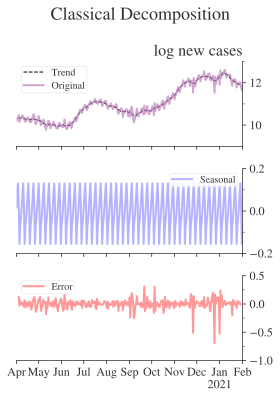

In [56]:
from matplotlib.ticker import AutoMinorLocator

def plot_seasonal_decomp(trend, seasonal, error, name):
    fig, axes = plt.subplots(nrows=3, sharex=True, figsize=(4, 5.5))
    plt.suptitle(name, y=1, x=0.5)
    axes[0].set_title("log new cases", loc="right")
    axes[0].set_ylim(9, 13)
    seasonal.plot(ax=axes[1], label="Seasonal", color="blue", alpha=0.3)
    trend.plot(ax=axes[0], linestyle="--", linewidth=1, color="k", label="Trend")
    df["new_cases"].plot(ax=axes[0], label="Original", alpha=0.7)
    error.plot(ax=axes[2], label="Error", color="red", alpha=0.4)
    for ax in axes:
        ax.yaxis.tick_right()
        ax.spines['right'].set_visible(True)
        ax.spines['left'].set_visible(False)
        ax.legend()
        ax.minorticks_off()
        ax.yaxis.set_minor_locator(AutoMinorLocator(n=2))
        ax.tick_params(axis='y', which='minor')
        ax.set_xlabel("")
    plt.tight_layout()


plot_seasonal_decomp(classical_trend, classical_seasonal, classical_resid, "Classical Decomposition")

### Exponential Smoothing

Exponential smoothing models provide a relatively simple way of estimating both the trend and seasonal factors simultaneously, in a single model. In addition, while the seasonal factors were not able to vary over time in the previous approach, it can in exponential smoothing models.

These models are sometimes referred to as ETS (Error, Trend, and Seasonal) because they can be seen as a generalisation of simple exponential smoothing to time series that contain trends and seasonalities. They have an underlying state space representation. An ETS model is specified by an error type (E; additive or multiplicative), a trend type (T; additive or multiplicative, both damped or undamped, or none), and a seasonality type (S; additive or multiplicative or none).

Here, we will use a simple exponential smoothing method that is assumed to be additive and has a trend. We'll use a *kwarg* of `initialization_method='concentrated'`, which estimates the initial values of the level, trend, and seasonal states by "concentrating" them out of the likelihood function.

In [59]:
# Construct the exponential smoothing model
ets_mod = sm.tsa.statespace.ExponentialSmoothing(
    df, trend=True, seasonal=7,
    initialization_method='concentrated')

# Fit the parameters of the model
ets_res = ets_mod.fit()

ets_seasonal = ets_res.states.smoothed['seasonal']
ets_trend = ets_res.states.smoothed['level']
ets_resid = ets_res.states.smoothed["error"]

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.12166D-01    |proj g|=  4.06544D-01

At iterate    5    f= -6.87789D-01    |proj g|=  5.75225D-03

At iterate   10    f= -6.89516D-01    |proj g|=  6.66378D-03

At iterate   15    f= -6.90517D-01    |proj g|=  1.78860D-03

At iterate   20    f= -6.90560D-01    |proj g|=  3.37494D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     23     24      1     0     0   7.374D-06  -6.906D-01
  F = -0.69056188800529261     

CONVERG

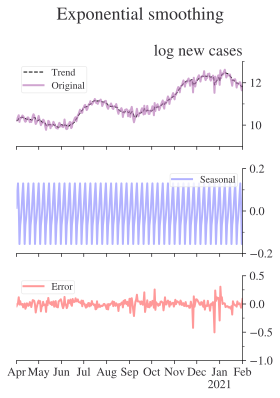

In [60]:
plot_seasonal_decomp(ets_trend, ets_seasonal, ets_resid, "Exponential smoothing")

### STL, or Seasonal-Trend Decomposition Based on Loess

A longer description of this approach may be found in section 3.7 of [Hyndman and Athanasopoulos (2021)](https://otexts.com/fpp3/stl.html). Like exponential smoothing models, seasonal factors estimated by STL can vary over time—and indeed, in this case, they do.

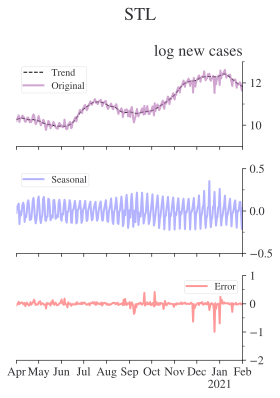

In [61]:
# Construct and fit the STL model, using the robust to (some) outliers feature
stl_mod = sm.tsa.STL(df, robust=True)
stl_res = stl_mod.fit()

plot_seasonal_decomp(stl_res.trend, stl_res.seasonal, stl_res.resid, "STL")

### Unobserved Components Model, aka Structural Time Series Model

Unobserved components models are extremely flexible, being able to support a variety of trend specifications, dummy variables, seasonal effects that vary over time, support for missing variables, support for autoregressive components, and support for missing observations, and support for exogenous variables. Let's build a model, albeit a simple one.

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.00275D+00    |proj g|=  1.55089D+00


 This problem is unconstrained.



At iterate    5    f= -3.24586D-01    |proj g|=  4.02210D+00
  ys=-2.432E-01  -gs= 2.182E-01 BFGS update SKIPPED

At iterate   10    f= -6.23529D-01    |proj g|=  8.42168D-01

At iterate   15    f= -6.23943D-01    |proj g|=  2.68248D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     16     39      1     1     0   2.974D-05  -6.239D-01
  F = -0.62394307890696077     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


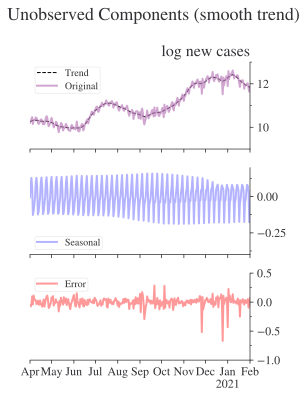

In [62]:
uc_mod = sm.tsa.UnobservedComponents(df, 'smooth trend', seasonal=7)
uc_res = uc_mod.fit()
uc_seasonal = uc_res.states.smoothed['seasonal']
uc_trend = uc_res.states.smoothed['level']
uc_resid = df["new_cases"] - uc_trend - uc_seasonal

# plot results
plot_seasonal_decomp(uc_trend, uc_seasonal, uc_resid, "Unobserved Components (smooth trend)")

### Other Seasonal Adjustment Approaches

[**X-13ARIMA-SEATS**](https://www.census.gov/data/software/x13as.X-13ARIMA-SEATS.html) is a commonly used programme produced by the U.S. Census Bureau. It supports monthly or quarterly, but not daily, data. If you have it installed on your computer, you can use it in **statsmodels** via `sm.tsa.x13_arima_analysis`.

[**TBATS**](https://github.com/intive-DataScience/tbats) is a relatively recent (circa 2011) econometric model that is particularly useful for data that exhibits multiple types of seasonality.

We have only scratched the surface of seasonal adjustment here by looking at trends and simple seasonality. There're a lot of extra features that can be exploited in the above models, for example adding dummies on dates for which there are events that cause known outliers, or controlling for known anomalies on some specific days. Which leads us neatly on to...



## Holidays

Everyone enjoys a holiday, except time series econometricians. Holidays mess up those neat models of seasonality we saw in the previous section. Have no fear though, because we are now going to look at some ways to account for holidays.

We'll be using the [**workalendar**](https://workalendar.github.io/workalendar/) package which, as ever, you may need to install separately. Workalendar is a Python module that can provide lists of secular and religious holidays for a wide range of countries. (An alternative package is [**holidays**](https://github.com/dr-prodigy/python-holidays)).) Once we have the right holidays for the right country, we can proceed to control for them.

Here's an example of grabbing holidays for the United States of America for 2020

In [63]:
from rich import print
from datetime import date
from workalendar.usa import UnitedStates

cal = UnitedStates()
usa_hols_21_22 = cal.holidays(2020) + cal.holidays(2021)
print(usa_hols_21_22)

[
    (datetime.date(2020, 1, 1), 'New year'),
    (datetime.date(2020, 1, 20), 'Birthday of Martin Luther King, Jr.'),
    (datetime.date(2020, 2, 17), "Washington's Birthday"),
    (datetime.date(2020, 5, 25), 'Memorial Day'),
    (datetime.date(2020, 7, 3), 'Independence Day (Observed)'),
    (datetime.date(2020, 7, 4), 'Independence Day'),
    (datetime.date(2020, 9, 7), 'Labor Day'),
    (datetime.date(2020, 10, 12), 'Columbus Day'),
    (datetime.date(2020, 11, 11), 'Veterans Day'),
    (datetime.date(2020, 11, 26), 'Thanksgiving Day'),
    (datetime.date(2020, 12, 25), 'Christmas Day'),
    (datetime.date(2021, 1, 1), 'New year'),
    (datetime.date(2021, 1, 18), 'Birthday of Martin Luther King, Jr.'),
    (datetime.date(2021, 2, 15), "Washington's Birthday"),
    (datetime.date(2021, 5, 31), 'Memorial Day'),
    (datetime.date(2021, 7, 4), 'Independence Day'),
    (datetime.date(2021, 7, 5), 'Independence Day (Observed)'),
    (datetime.date(2021, 9, 6), 'Labor Day'),
    (datetime.date(2021, 10, 11), 'Columbus Day'),
    (datetime.date(2021, 11, 11), 'Veterans Day'),
    (datetime.date(2021, 11, 25), 'Thanksgiving Day'),
    (datetime.date(2021, 12, 24), 'Christmas Day (Observed)'),
    (datetime.date(2021, 12, 25), 'Christmas Day'),
    (datetime.date(2021, 12, 31), 'New Years Day (Observed)')
]

If you got to grips with types in the {ref}`code-basics` chapter, you'll know that this is a list of tuples. The first entry in each tuple is a datetime, the second is the name of the holiday.

As well as this national representation of the USA's holidays, state level holiday lists are available. To see the available countries, check the github page or use Visual Studio Code's autocomplete (type `import workalendar.` and the country and continent options should appear; type `import workalendar.europe.` to see the European countries).

Let's put these holidays into a dataframe.

In [64]:
df_hols = pd.DataFrame(usa_hols_21_22, columns=["date", "holiday"])
df_hols = df_hols.assign(date=lambda x: pd.to_datetime(x["date"]))
df_hols

,date,holiday
0,2020-01-01,New year
1,2020-01-20,"Birthday of Martin Luther King, Jr."
2,2020-02-17,Washington's Birthday
3,2020-05-25,Memorial Day
...,...,...
20,2021-11-25,Thanksgiving Day
21,2021-12-24,Christmas Day (Observed)
22,2021-12-25,Christmas Day
23,2021-12-31,New Years Day (Observed)


How might we be able to use this in analysis? Let's merge it with our COVID-19 data. Note that we're only interested in holidays that fall within the date range of our COVID data so when we do the merge, we use `how="right"`. We're also resetting the index so that `date` appears as column in *both* dataframes (and making the `date` the index again afterwards with `set_index`)

In [65]:
df = pd.merge(df_hols, df.reset_index(), how="right", on="date").set_index("date")
df.iloc[-19:-11]

,holiday,new_cases
date,,
2021-01-14,NaN,12.386401
2021-01-15,NaN,12.387782
2021-01-16,NaN,12.216978
2021-01-17,NaN,12.044107
2021-01-18,"Birthday of Martin Luther King, Jr.",11.857458
2021-01-19,NaN,12.138564
2021-01-20,NaN,12.130745
2021-01-21,NaN,12.157313


Let's create a new column with a dummy for when a date is a holiday:

In [66]:
df["dummy"] = 0
df.loc[~pd.isna(df["holiday"]), "dummy"] = 1
df.iloc[-19:-11]

,holiday,new_cases,dummy
date,,,
2021-01-14,NaN,12.386401,0
2021-01-15,NaN,12.387782,0
2021-01-16,NaN,12.216978,0
2021-01-17,NaN,12.044107,0
2021-01-18,"Birthday of Martin Luther King, Jr.",11.857458,1
2021-01-19,NaN,12.138564,0
2021-01-20,NaN,12.130745,0
2021-01-21,NaN,12.157313,0


Now we have a dataset with new cases by date and with a dummy indicator for whether a period is a holiday or not. A typical way of including the effect of holidays in a regression would be to use a model like the following:

$$
y_t = \mu_t + \gamma_t + \underbrace{\beta_1 x_{1t}}_\text{Thanksgiving} + \underbrace{\beta_2 x_{2t}}_\text{Christmas} + \underbrace{\beta_3 x_{3t}}_\text{New Year's Day} + \varepsilon_t
$$

This is very similar to the seasonal only model we saw in the previous section, it just has a small number of dedicated dummy variables to capture the effects of a holiday. To create the design matrix for a regression that directly made use of these dummy variables, we could use **pandas** get dummies function (use `drop_first=True` if you have a constant term and want to avoid the dummy variable trap):

In [67]:
pd.get_dummies(df, "dummy").iloc[-40:-35]

,new_cases,dummy,"dummy_Birthday of Martin Luther King, Jr.",dummy_Christmas Day,dummy_Columbus Day,dummy_Independence Day,dummy_Independence Day (Observed),dummy_Labor Day,dummy_Memorial Day,dummy_New year,dummy_Thanksgiving Day,dummy_Veterans Day
date,,,,,,,,,,,,
2020-12-24,12.173090,0,0,0,0,0,0,0,0,0,0,0
2020-12-25,11.522192,1,0,1,0,0,0,0,0,0,0,0
2020-12-26,12.287012,0,0,0,0,0,0,0,0,0,0,0
2020-12-27,11.932221,0,0,0,0,0,0,0,0,0,0,0
2020-12-28,12.149555,0,0,0,0,0,0,0,0,0,0,0


### Seasonal and Holiday Adjustment

Although directly carrying out regressions with dummy variables is one way to control for holidays, some models offer an easier alternative and now we're going to take an example from the previous section, on seasonal adjustment, to show how.

We'll use the unobserved components model because that allows us to pass in an `exog` series full of seasonal dummy variables.

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.81463D-01    |proj g|=  1.60210D+00

At iterate    5    f= -3.25129D-01    |proj g|=  3.29155D+00


 This problem is unconstrained.



At iterate   10    f= -6.85052D-01    |proj g|=  3.23266D+00

At iterate   15    f= -7.71125D-01    |proj g|=  1.55939D-01

At iterate   20    f= -7.73498D-01    |proj g|=  1.34792D+00

At iterate   25    f= -7.74148D-01    |proj g|=  1.01328D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     52      1     0     0   1.013D-04  -7.741D-01
  F = -0.77414806699262395     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


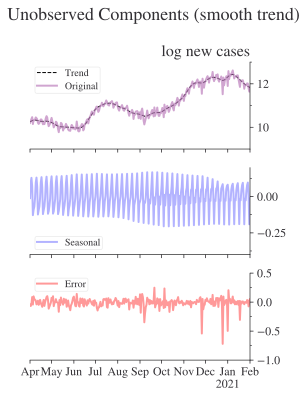

In [68]:
uc_hols_mod = sm.tsa.UnobservedComponents(df["new_cases"], 'smooth trend', seasonal=7, exog=df["dummy"])
uc_hols = uc_hols_mod.fit()
uc_hols_seasonal = uc_hols.states.smoothed['seasonal']
uc_hols_trend = uc_hols.states.smoothed['level']
uc_hols_resid = df["new_cases"] - uc_hols_trend - uc_hols_seasonal

# plot results
plot_seasonal_decomp(uc_hols_trend, uc_hols_seasonal, uc_hols_resid, "Unobserved Components (smooth trend)")

Did this model do better than the same unobserved components model without the dummy indicators for holidays? We can test that directly:

In [69]:
print(f"The error was {(uc_hols_resid/uc_resid).mean()*100:.0f}% of the model without holidays.")

The error was 89% of the model without holidays.

So, indeed, adding holidays as exogenous factors created a *reduction* in error in the model. 

```{admonition} Exercise
Explore how consistent the reduction in error is. You may want to plot some exploratory charts, including a `hist`.
```

## Granger Causality

Granger causality is not causality at all; you can find out more about that in the Chapter on {ref}`econmet-causal-inference`! What this test really tells us is whether two series are temporally related, and if one series is useful for predicting another. More formally, a time series $x_t$ Granger-causes another time series $y_t$ if predictions of the value of $y_t$ based on its own past values *and* on the past values of $x$ are better than predictions of $y$ based only on $y$'s own past values.

The null for a Granger causality test is that $x$ does not provide additional value for predicting $y$.

**statsmodels** provides a convenient method for performing Granger causality tests within its `tsa.stattools` module. The test asks whether the time series in the second column Granger causes the time series in the first column, ie use it as `test(caused, causing)`.

Let's load some macroeconomic data to run the test on:

In [70]:
from statsmodels.tsa.stattools import grangercausalitytests
data = sm.datasets.macrodata.load_pandas()
data = data.data[["realgdp", "realcons"]].pct_change().dropna()
data.head()

,realgdp,realcons
1,0.025256,0.015404
2,-0.001192,0.010440
3,0.003501,0.001085
4,0.022438,0.009580
5,-0.004674,0.012652


And now the test of whether (growth in) real consumption Granger causes (growth in) real GDP. We will use 1 lag. The Granger test actually produces a set of statistics and returns a dictionary that contains all of them (it's first key is the lag).

In [71]:
granger_results = grangercausalitytests(data, maxlag=1)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=28.7248 , p=0.0000  , df_denom=198, df_num=1
ssr based chi2 test:   chi2=29.1600 , p=0.0000  , df=1
likelihood ratio test: chi2=27.2295 , p=0.0000  , df=1
parameter F test:         F=28.7248 , p=0.0000  , df_denom=198, df_num=1


In this case, there's an emphatic relationship between the series. When choosing lags, note that there is a trade-off between bias and power. With too few lags the test may be biased because of residual auto-correlation. Too many, and you risk spurious rejections of the null because of random correlations. For more on how to properly choose lags and perform this test, look at the [entry on Granger tests on Dave Giles' blog](https://davegiles.blogspot.com/2011/04/testing-for-granger-causality.html).

## Breaks and Changepoint Detection

> Everything you say to me  
> Takes me one step closer to the edge  
> And I'm about to break  

—— Linkin Park, Hybrid Theory (2000); also, time series

COVID-19 has brought a period of extreme structural change in the economy, and in time series related to the economy. It is useful to have tests for when time series have fundamentally changed due to a *break* or *changepoint*. What do we mean by fundamentally? The *moments* have changed; the mean, the variance, and so on.

Note that this is different from an anomaly, which is an outlier. A break suggests a change that has occurred between the before times and the after times; an anomaly is an observation that seems not to fit an ongoing pattern.

Perhaps the most widely used changepoint detection package is [**ruptures**](https://github.com/deepcharles/ruptures). Let's see if we can detect some distinct changes in the growth of the UK's productivity (measured per hour).

In [72]:
import requests

series_id = "PRDY"
timeseries_id = "LZVC"


url = f"https://api.ons.gov.uk/timeseries/{timeseries_id}/dataset/{series_id}/data"

# Get the data from the ONS API:
df = pd.DataFrame(pd.json_normalize(requests.get(url).json()["quarters"]))
df["value"] = pd.to_numeric(df["value"])
df = df[["date", "value"]]
df = df.rename(columns={"value": "Output per hour: growth"})
# Convert 1959 Q3 format to a proper datetime, eg 1959-09-30
df["date"] = pd.to_datetime(df["date"].apply(lambda x: x[:4] + "-" + str(int(x[-1])*3)), format="%Y-%m") + pd.DateOffset(months=1, days=-1)
df = df.set_index("date")
df.head()

,Output per hour: growth
date,
1972-03-31,0.5
1972-06-30,1.2
1972-09-30,1.8
1972-12-31,2.4
1973-03-31,2.5


**ruptures** has many offline changepoint detection methods, some of which require the user to supply the number of breaks. Let's look at a fully *unsupervised* algorithm, Pelt, which stands for Penalised change point detection.

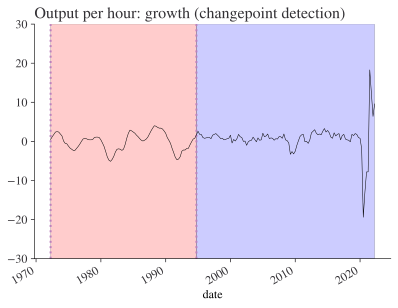

In [73]:
import ruptures as rpt
from itertools import cycle

# detection
model = rpt.Pelt(model="rbf").fit(df["Output per hour: growth"].values)
break_indices = model.predict(pen=5)


def plot_break_points(data, col, brk_pts):
    fig, ax = plt.subplots()
    color_cycle = cycle(["red", "blue"])
    # change brk_pts results to index positions:
    positions = [data.index[0]] + [data.index[entry] for entry in brk_pts[:-1]] + [data.index[-1]]
    # change positions to pairs of positions
    pairs_pos = [(a, b) for a, b in zip(positions, positions[1:])]
    # iterate over pairs of positions:
    for i, (start, end) in enumerate(pairs_pos):
        ax.axvspan(start, end, alpha=0.2, facecolor=next(color_cycle))
        # vertical lines to mark the break points
        ax.axvline(
            x=start,
            linestyle=":",
        )
    data[col].plot(ax=ax, color="black", linewidth=0.5)
    ax.set_title(col + " (changepoint detection)")
    plt.show()


plot_break_points(df, "Output per hour: growth", break_indices)

This looks plausible, but you can get very different results depending on the value you use for the penalty (`pen=`)

We can manufacture a clearer example by creating some fake data:

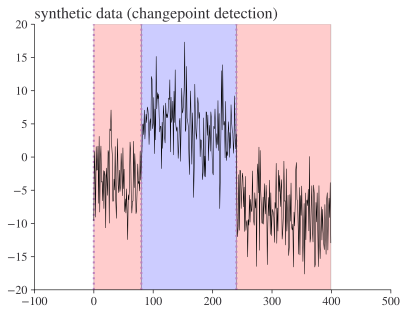

In [74]:
# generate signal
n_samples, dim, sigma = 400, 1, 4
n_bkps = 4  # number of breakpoints
signal, bkps = rpt.pw_constant(n_samples, dim, n_bkps, noise_std=sigma, seed=seed_for_prng)
signal = pd.DataFrame(signal, columns=["synthetic data"])

# detection
model = rpt.Pelt(model="rbf").fit(signal["synthetic data"].values)
break_indices = model.predict(pen=5)

plot_break_points(signal, "synthetic data", break_indices)

### See Also

Although **ruptures** contains a number of changepoint detection algorithms, it's not the only package around. Facebook has developed both [**prophet**](https://facebook.github.io/prophet/), which is a Bayesian auto-time series prediction package that comes with break point detection, and [**kats**](https://facebookresearch.github.io/Kats/), which uses a cumulative sum-based changepoint detection algorithm. For the matrix profile approach, see [**matrixprofile-ts**](https://github.com/target/matrixprofile-ts) and [**stumpy**](https://stumpy.readthedocs.io/en/latest/). The [**sdt**](https://schuetzgroup.github.io/sdt-python/changepoint.html) library, while ostensibly for fluorescence microscopy, provides online and offline Bayesian changepoint detection.